In [ ]:
import os
root_path = '/raid/ee-mariyam/maryam/abhijeet/Combined_Files'
def get_jpg_paths(base_dir):
    jpg_dict = {}
    
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        
        if os.path.isdir(folder_path):
            jpg_paths = []
            
            for file_name in os.listdir(folder_path):
                if file_name.lower().endswith('.jpg'):
                    file_path = os.path.join(folder_path, file_name)
                    jpg_paths.append(file_path)
            
            if jpg_paths:
                jpg_dict[folder_name] = jpg_paths
    
    return jpg_dict

combined_files_path = root_path
class_files = get_jpg_paths(combined_files_path)


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler, AutoencoderKL
from diffusers.optimization import get_cosine_schedule_with_warmup
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import warnings
import torchvision.transforms as transforms

In [ ]:
config = {
    "pretrained_model": "runwayml/stable-diffusion-v1-5",
    "batch_size": 32,
    "gradient_accumulation_steps": 4,
    "learning_rate": 1e-5,
    "num_epochs": 30,
    "resolution": 512,
    "enable_xformers": False,
    "train_text_encoder": False,
    "use_8bit_optimizer": True,
}

In [ ]:
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def load_models():
    pipe = StableDiffusionPipeline.from_pretrained(
        config["pretrained_model"],
        torch_dtype=torch.float32,
        safety_checker=None,
        requires_safety_checker=False
    )

    vae = pipe.vae.to(device)
    text_encoder = pipe.text_encoder.to(device)
    tokenizer = pipe.tokenizer
    unet = pipe.unet.to(device)
    noise_scheduler = pipe.scheduler

    vae.requires_grad_(False)
    text_encoder.requires_grad_(config["train_text_encoder"])

    unet.enable_gradient_checkpointing()

    return vae, text_encoder, tokenizer, unet, noise_scheduler

vae, text_encoder, tokenizer, unet, noise_scheduler = load_models()


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 22.58it/s]


In [ ]:
class DiffusionDataset(Dataset):
    def __init__(self, class_files, tokenizer, size=512):
        self.tokenizer = tokenizer
        self.size = size
        self.samples = []

        for class_name, files in class_files.items():
            for file_path in files:
                self.samples.append((file_path, class_name))

        self.fallback_image = torch.zeros((3, size, size), dtype=torch.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]

        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB")
                img = img.resize((self.size, self.size))
                image = np.array(img).astype(np.float32) / 127.5 - 1.0
                image = torch.from_numpy(image).permute(2, 0, 1)
        except Exception as e:
            warnings.warn(f"Error loading {img_path}: {e}")
            image = self.fallback_image

        text_input = self.tokenizer(
            class_name,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )

        return {
            "pixel_values": image,
            "input_ids": text_input.input_ids[0]
        }


In [ ]:
dataset = DiffusionDataset(class_files, tokenizer)
dataloader = DataLoader(
    dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    pin_memory=True,
    num_workers=128,
    persistent_workers=True
)

if config["use_8bit_optimizer"]:
    import bitsandbytes as bnb
    optimizer = bnb.optim.AdamW8bit(
        unet.parameters(),
        lr=config["learning_rate"],
        weight_decay=1e-2
    )
else:
    optimizer = torch.optim.AdamW(
        unet.parameters(),
        lr=config["learning_rate"],
        weight_decay=1e-2
    )

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=len(dataloader) * config["num_epochs"]
)


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import matplotlib.pyplot as plt

train_losses = []
fid_scores = []
is_scores = []
is_std_devs = []

fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
is_metric = InceptionScore(feature=2048, normalize=True).to(device)

def generate_samples(pipe, num_samples=50):
    latents = torch.randn((num_samples, 4, 64, 64), device=device)
    images = pipe.decode_latents(latents).clamp(0, 1)
    return images

for epoch in range(config["num_epochs"]):
    unet.train()
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")

    for step, batch in enumerate(progress_bar):
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)

        with torch.no_grad():
            latents = vae.encode(pixel_values).latent_dist.sample()
            latents = latents * 0.18215
            encoder_hidden_states = text_encoder(input_ids)[0]

        noise = torch.randn_like(latents)
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (latents.size(0),), device=device
        ).long()

        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

        loss = F.mse_loss(noise_pred, noise)
        loss = loss / config["gradient_accumulation_steps"]
        loss.backward()

        if (step + 1) % config["gradient_accumulation_steps"] == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            lr_scheduler.step()

        running_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    avg_loss = running_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Training Loss = {avg_loss:.4f}")
unet.save_pretrained("./DDP2_Diffusion/fine_tuned_unet1")
print("Model saved to ./DDP2_Diffusion/fine_tuned_unet1")


Epoch 1/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream whe

Epoch 1: Training Loss = 0.0470


Epoch 2/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream whe

Epoch 2: Training Loss = 0.0471


Epoch 3/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream whe

Epoch 3: Training Loss = 0.0456


Epoch 4/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream whe

Epoch 4: Training Loss = 0.0469


Epoch 5/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream whe

Epoch 5: Training Loss = 0.0464


Epoch 6/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream whe

Epoch 6: Training Loss = 0.0468


Epoch 7/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream whe

Epoch 7: Training Loss = 0.0454


Epoch 8/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream whe

Epoch 8: Training Loss = 0.0475


Epoch 9/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream whe

Epoch 9: Training Loss = 0.0455


Epoch 10/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream wh

Epoch 10: Training Loss = 0.0462


Epoch 11/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream wh

Epoch 11: Training Loss = 0.0472


Epoch 12/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream wh

Epoch 12: Training Loss = 0.0449


Epoch 13/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream wh

Epoch 13: Training Loss = 0.0454


Epoch 14/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream wh

Epoch 14: Training Loss = 0.0449


Epoch 15/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream wh

Epoch 15: Training Loss = 0.0457


Epoch 16/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream wh

Epoch 16: Training Loss = 0.0443


Epoch 17/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
Epoch 17/30:   1%|          | 2/167 [00:16<20:21,  7.41s/it, loss=0.0394]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_F

Epoch 17: Training Loss = 0.0455


Epoch 18/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream wh

Epoch 18: Training Loss = 0.0451


Epoch 19/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream wh

Epoch 19: Training Loss = 0.0437


Epoch 20/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream wh

Epoch 20: Training Loss = 0.0459


Epoch 21/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream wh

Epoch 21: Training Loss = 0.0455


Epoch 22/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream wh

Epoch 22: Training Loss = 0.0445


Epoch 23/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream wh

Epoch 23: Training Loss = 0.0441


Epoch 24/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream wh

Epoch 24: Training Loss = 0.0437


Epoch 25/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream wh

Epoch 25: Training Loss = 0.0455


Epoch 26/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
Epoch 26/30: 100%|██████████| 167/167 [09:03<00:00,  3.25s/it, loss=0.0488]


Epoch 26: Training Loss = 0.0446


Epoch 27/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream wh

Epoch 27: Training Loss = 0.0453


Epoch 28/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream wh

Epoch 28: Training Loss = 0.0464


Epoch 29/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream wh

Epoch 29: Training Loss = 0.0453


Epoch 30/30:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
  warnings.warn(f"Error loading {img_path}: {e}")
/tmp/ipykernel_591107/2282372177.py:30: UserWarning: Error loading /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream wh

Epoch 30: Training Loss = 0.0454
Model saved to ./DDP2_Diffusion/fine_tuned_unet1


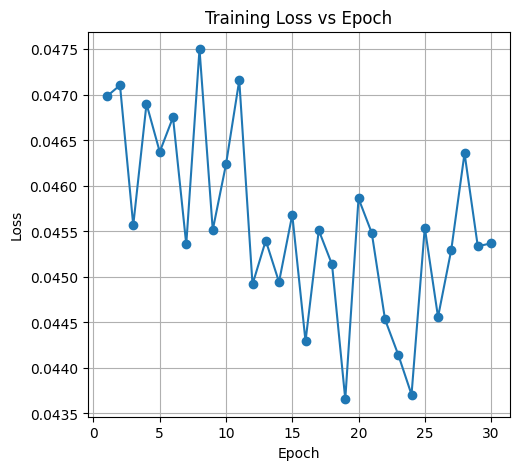

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, config["num_epochs"] + 1), train_losses, marker='o')
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

In [ ]:
if fid_scores:
    metric_epochs = list(range(config["metric_interval"], config["num_epochs"] + 1, config["metric_interval"]))

    plt.subplot(1, 2, 2)
    plt.plot(metric_epochs, fid_scores, label="FID", marker='s', color='red')
    plt.errorbar(metric_epochs, is_scores, yerr=is_std_devs, label="Inception Score", marker='o', color='blue')
    plt.title("FID and IS vs Epoch")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler, AutoencoderKL
from diffusers.optimization import get_cosine_schedule_with_warmup
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import warnings
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import CLIPFeatureExtractor
from diffusers import DDIMScheduler



pretrained_model = "runwayml/stable-diffusion-v1-5"
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

fine_tuned_unet = UNet2DConditionModel.from_pretrained(
    "./DDP2_Diffusion/fine_tuned_unet1",
    torch_dtype=dtype
).to(device)

vae = AutoencoderKL.from_pretrained(
    config["pretrained_model"],
    subfolder="vae",
    torch_dtype=dtype
).to(device)

text_encoder = CLIPTextModel.from_pretrained(
    config["pretrained_model"],
    subfolder="text_encoder",
    torch_dtype=dtype
).to(device)

tokenizer = CLIPTokenizer.from_pretrained(
    config["pretrained_model"],
    subfolder="tokenizer"
)

feature_extractor = CLIPFeatureExtractor.from_pretrained(
    config["pretrained_model"],
    subfolder="feature_extractor"
)

pipe = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=fine_tuned_unet,
    scheduler=DDIMScheduler.from_pretrained(config["pretrained_model"], subfolder="scheduler"),
    feature_extractor=feature_extractor,
    safety_checker=None,
    requires_safety_checker=False
).to(device)

if torch.cuda.is_available():
    pipe.unet = pipe.unet.half()
    pipe.vae = pipe.vae.half()
    pipe.text_encoder = pipe.text_encoder.half()

pipe.enable_attention_slicing()
if torch.cuda.is_available():
    try:
        pipe.enable_xformers_memory_efficient_attention()
    except:
        print("xformers not available, proceeding without it")

def generate_image(prompt, num_inference_steps=50, guidance_scale=7.5):
    with torch.no_grad():
        image = pipe(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            height=config["resolution"],
            width=config["resolution"],
        ).images[0]
    return image


/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet_py311/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:30: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


xformers not available, proceeding without it


Generating image for class: Purple_Blotch


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 19.60it/s]


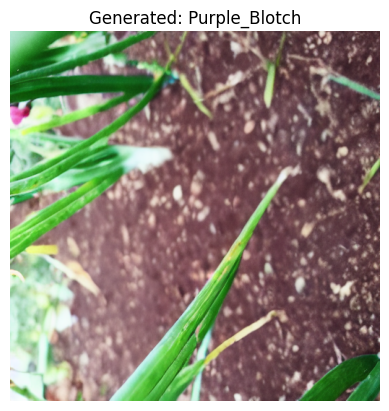

Generating image for class: Thrips


100%|██████████| 50/50 [00:02<00:00, 20.07it/s]


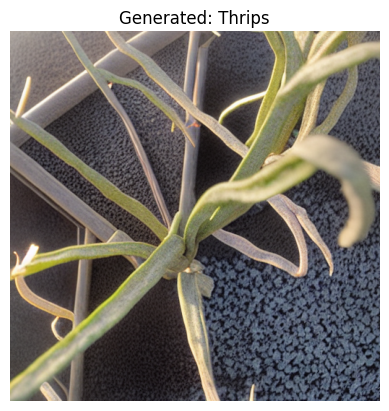

Generating image for class: IYSV


100%|██████████| 50/50 [00:02<00:00, 18.75it/s]


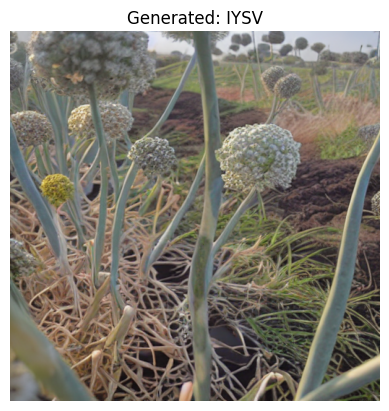

Generating image for class: Twister


100%|██████████| 50/50 [00:02<00:00, 20.34it/s]


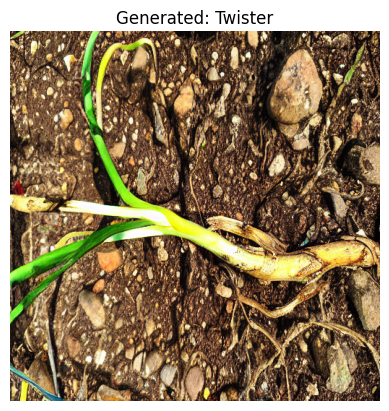

Generating image for class: Healthy


100%|██████████| 50/50 [00:02<00:00, 19.28it/s]


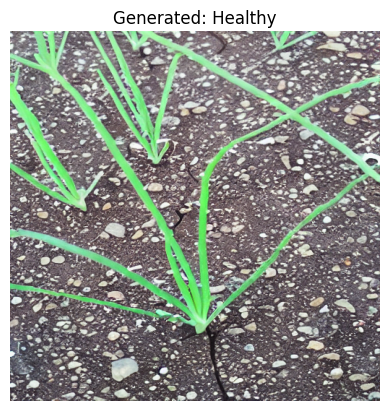

Generating image for class: Bulb Rot


100%|██████████| 50/50 [00:02<00:00, 20.55it/s]


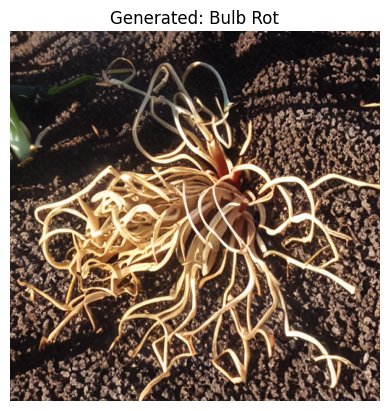

Generating image for class: Basal_Rot


100%|██████████| 50/50 [00:02<00:00, 20.81it/s]


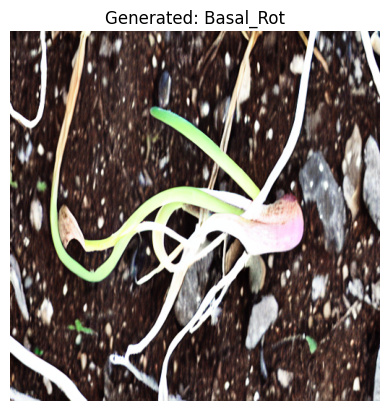

Generating image for class: Stemphylium


100%|██████████| 50/50 [00:02<00:00, 20.28it/s]


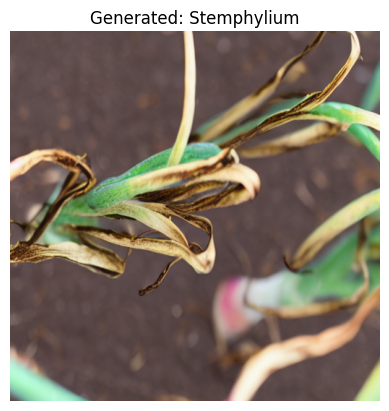

Generating image for class: Anthracnose


100%|██████████| 50/50 [00:02<00:00, 19.70it/s]


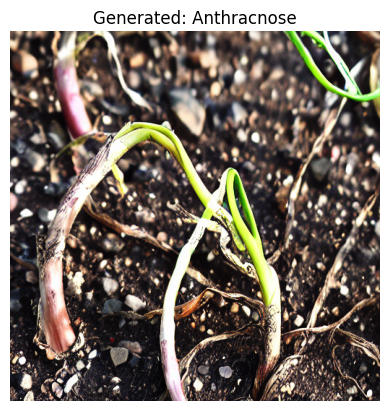

In [25]:
from PIL import Image
import os
import matplotlib.pyplot as plt
class_names = list(class_files.keys())

for class_name in class_names:
    print(f"Generating image for class: {class_name}")

    image = generate_image(class_name)  
    plt.imshow(np.array(image))
    plt.axis('off')
    plt.title(f"Generated: {class_name}")
    plt.show()

 20%|██        | 10/50 [00:00<00:01, 20.01it/s]

100%|██████████| 50/50 [00:02<00:00, 19.67it/s]


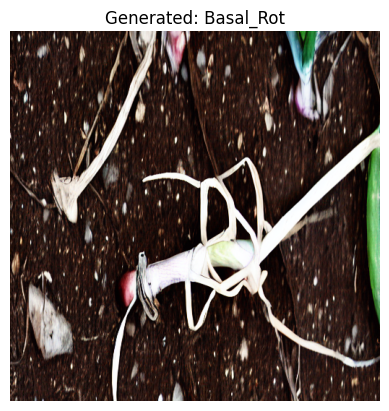

In [26]:
class_name = 'Basal_Rot'
image = generate_image(class_name)  
plt.imshow(np.array(image))
plt.axis('off')
plt.title(f"Generated: {class_name}")
plt.show()